# Differential photometry

After an observation is done, a common need is to reduce and extract fluxes from raw FITS images. 

In this tutorial you will learn how to process a complete night of raw data from any telescope with some basic reduction tools provided by *prose*.

## Example data

You can follow this tutorial on your own data or generate a synthetic dataset. As an example, let's generate a light curve

(0.98, 1.02)

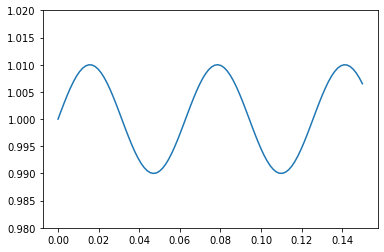

In [2]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 0.15, 100)
target_dflux = 1 + np.sin(time*100)*1e-2

plt.plot(time, target_dflux)
plt.ylim(0.98, 1.02)

This might be the differential flux of a variable star. Let's now simulate the fits images associated with the observation of this target:

In [3]:
from prose.tutorials import simulate_observation

# so we have the same data
np.random.seed(40)

fits_folder = "./tutorial_dataset"
simulate_observation(time, target_dflux, fits_folder)

100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


here prose simulated comparison stars, there fluxes over time and some systematics noises.

## Telescope setting

We start by setting up the `Telescope` information we need for the reduction, for example some fits keywords that are specific to this observatory plus few specs:

In [4]:
from prose import Telescope

_ = Telescope({
    "name": "A",
    "trimming": [40, 40],
    "pixel_scale": 0.66,
    "latlong": [31.2027, 7.8586],
    "keyword_light_images": "light"
})

Telescope 'a' saved


This has to be done **only once** and saves this telescope settings for any future use (whenever its name appears in fits headers). More details are given in the [telescope settings](../api/telescope.rst) note.

## Folder exploration

The first thing we want to do is to see what is contained within our folder. For that we instantiate a `FitsManager` object on our folder to describe its content

In [5]:
from prose import FitsManager

fm = FitsManager(fits_folder, depth=2)
fm.calib

100%|██████████| 106/106 [00:00<00:00, 690.60it/s]

╒════════════╤═════════════╤══════════╤══════════╤════════╤════════════╕
│ date       │ telescope   │ target   │ filter   │ type   │   quantity │
╞════════════╪═════════════╪══════════╪══════════╪════════╪════════════╡
│ 2021-01-28 │ A           │ prose    │          │ bias   │          1 │
├────────────┼─────────────┼──────────┼──────────┼────────┼────────────┤
│ 2021-01-28 │ A           │ prose    │          │ dark   │          1 │
├────────────┼─────────────┼──────────┼──────────┼────────┼────────────┤
│ 2021-01-28 │ A           │ prose    │ a        │ flat   │          4 │
├────────────┼─────────────┼──────────┼──────────┼────────┼────────────┤
│ 2021-01-28 │ A           │ prose    │ a        │ light  │        100 │
╘════════════╧═════════════╧══════════╧══════════╧════════╧════════════╛



/Users/lionelgarcia/Code/envs/prose/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


We have 80 images of the *prose* target together with some calibration files. More info about the `FitsManager` object [here](./fits_manager.ipynb).

## Reduction and Photometry

*prose* provides basic pipelines for reduction and photometry. Using these, the `Reduction` is simply

In [6]:
from prose import Reduction

reduction = Reduction(fm)
reduction.run()

RUN Reduction: 100%|███████████████████████| 100/100 [00:09<00:00, 10.59files/s]


The previously set telescope has been recognized and a `A_20210128_prose_a` folder has been created in which we can now run the `AperturePhotometry`.

In [7]:
from prose import AperturePhotometry

photometry = AperturePhotometry(reduction.destination)
photometry.run()

100%|██████████| 101/101 [00:00<00:00, 551.56it/s]


INFO detected stars: 19
INFO global psf FWHM: 3.83 (pixels)


RUN Photometry: 100%|██████████████████████| 100/100 [00:13<00:00,  7.26files/s]


Here is the content of the reduced folder:

```
A_20210128_prose_a/
  │ 
  ├── A_20210128_prose_a.phot
  ├── A_20210128_prose_a.gif
  ├── fake-im-0_reduced.fits
  ├── fake-im-1_reduced.fits
  ├── fake-im-2_reduced.fits
  └── ...
```

It contains:

- all reduced images
- a ``phot`` file containing all extracted fluxes and stack image (see [data products description](./phot.ipynb))
- a ``gif`` of the night 

`Reduction` and `AperturePhotometry` are `Unit` objects modularly built out of `Block`. Such pipelines can be built from scratch and even contain custom `Block` (like in the [next tutorial](./custom_pipeline.ipynb)).

## Photometry analysis

Let's load our data into an `Observation` object containing all we need for this analysis and show the detected stars

INFO Time converted to BJD TDB


<Figure size 432x288 with 0 Axes>

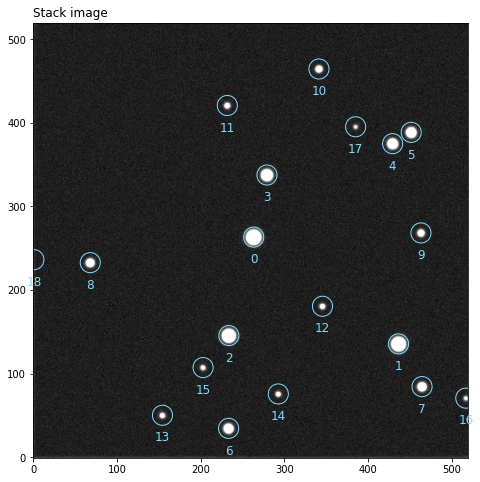

In [8]:
from prose import load

obs = load(photometry.phot_path)
obs.show_stars(size=8)

In [9]:
obs

<xarray.Dataset>
Dimensions:          (apertures: 40, h: 520, n: 2, star: 19, time: 100, w: 520)
Coordinates:
    stack            (w, h) float64 306.2 306.3 307.2 ... 297.7 300.3 299.1
  * time             (time) float64 -0.004345 -0.00283 ... 0.1441 0.1456
    stars            (star, n) float64 263.3 263.4 436.5 ... 395.3 0.4541 236.4
Dimensions without coordinates: apertures, h, n, star, w
Data variables:
    fluxes           (apertures, star, time) float64 2.392e+04 ... -4.798e+05
    errors           (apertures, star, time) float64 164.7 169.2 ... 2.468e+03
    sky              (time) float64 296.6 296.6 296.4 ... 296.5 296.4 296.3
    fwhm             (time) float64 4.988 3.784 4.642 ... 3.556 4.412 3.309
    fwhmx            (time) float64 4.988 3.784 4.642 ... 3.556 4.412 3.309
    fwhmy            (time) float64 4.988 3.784 4.642 ... 3.556 4.412 3.309
    dx               (time) float64 1.907 3.551 1.736 ... 0.6126 1.888 2.14
    dy               (time) float64 1.893 3.173 1.688 ... 0.1566 1.862 2.095
    airmass          (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    exptime          (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    jd_utc           (time) float64 0.0 0.001515 0.00303 ... 0.147 0.1485 0.15
    seeing           (time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    ra               (time) float64 12.84 12.84 12.84 ... 12.84 12.84 12.84
    dec              (time) float64 -22.86 -22.86 -22.86 ... -22.86 -22.86
    apertures_area   (time, apertures) float64 0.4605 5.641 ... 4.468e+03
    annulus_area     (time) float64 1.796e+03 1.796e+03 ... 1.796e+03 1.796e+03
    apertures_radii  (time, apertures) float64 0.3829 1.34 2.297 ... 36.75 37.71
    annulus_rin      (time) float64 19.14 19.14 19.14 ... 19.14 19.14 19.14
    annulus_rout     (time) float64 30.63 30.63 30.63 ... 30.63 30.63 30.63
    bjd_tdb          (time) float64 -0.004345 -0.00283 ... 0.1441 0.1456
Attributes:
    target:       -1
    aperture:     -1
    telescope:    A
    filter:       a
    exptime:      1
    name:         prose
    date:         20210128
    SIMPLE:       1
    BITPIX:       -64
    NAXIS:        2
    NAXIS1:       520
    NAXIS2:       520
    TELESCOP:     A
    EXPTIME:      1
    FILTER:       a
    OBJECT:       prose
    IMAGETYP:     Stack image
    AIRMASS:      1
    JD:           0.07575757575757576
    RA:           12.84412
    DEC:          -22.85886
    DATE-OBS:     2021-01-28T20:29:06.562
    WCSAXES:      2
    CRPIX1:       -40.0
    CRPIX2:       -40.0
    CDELT1:       1.0
    CDELT2:       1.0
    CRVAL1:       0.0
    CRVAL2:       0.0
    LATPOLE:      90.0
    WCSNAME:      DEFAULTS
    MJD-OBS:      59242.853548171
    REDDATE:      2021-01-28T19:29:35.601
    NIMAGES:      100
    FWHM:         3.828558295496158
    FWHMX:        3.7909246740663
    FWHMY:        3.8661919169260157
    PSFANGLE:     0.31648543858806344
    FWHMALG:      Gaussian2D
    time_format:  bjd_tdb

<div class="alert alert-info">

Note

More details on the structure of these data products (and the representation above) in [data products description](./phot.ipynb)

</div>

If target was not specified in the reduction process (with a value of -1 as shown above), we need to specify it before producing our differential Photometry.

(0.98, 1.02)

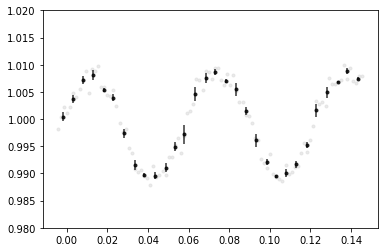

In [10]:
obs.target = 0
df = obs.broeg2005()
df.plot()
plt.ylim(0.98, 1.02)

<div class="alert alert-info">

Note

We could also have picked the comparison stars ourselves using ``diff`` from `Observation`

</div>

We used the Broeg 2005 algorithm to build the differential light-curve and ended by plotting it. We can check the comparison stars with

<Figure size 432x288 with 0 Axes>

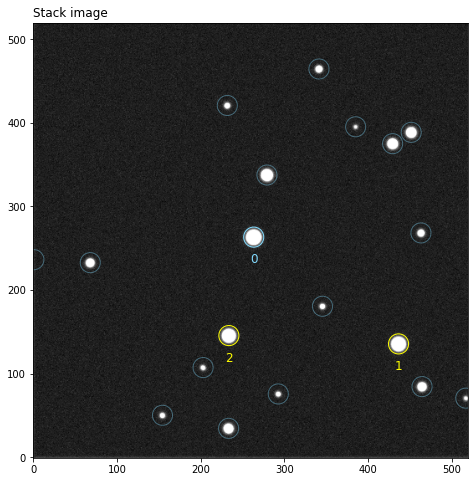

In [11]:
df.show_stars(size=8)

and continue with further visualisation or analysis. All available plotting and analysis methods are described in `Observation`.

To save your analysis into the same phot file

In [12]:
df.save()

## Some more details

### `Observation` plots

From the `Observation` object many things can be plotted. For example here are the comparison light curves as well as the systematics data:

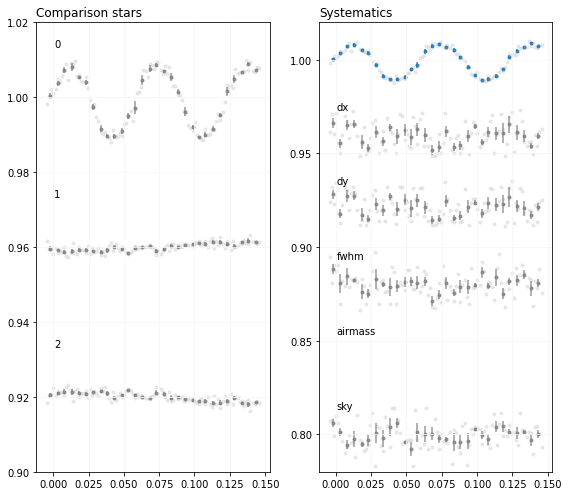

In [13]:
plt.figure(figsize=(8, 7))

plt.subplot(121)
df.plot_comps_lcs()

plt.subplot(122)
df.plot_systematics()

or effective some psf information

{'theta': 0.31648543858806344,
 'std_x': 1.609857484467131,
 'std_y': 1.6418205395712955,
 'fwhm_x': 3.7909246740663,
 'fwhm_y': 3.8661919169260157}

<Figure size 432x288 with 0 Axes>

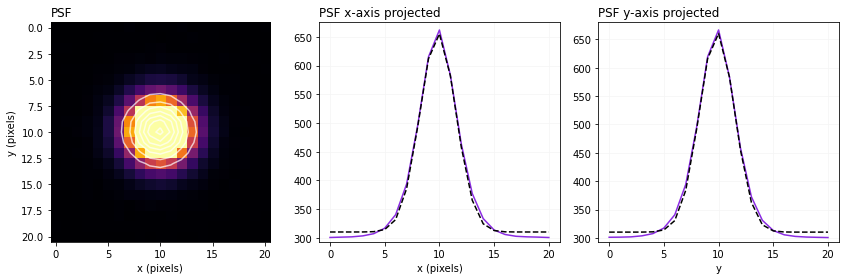

In [14]:
df.plot_psf_fit()

here is another useful one showing the raw fluxes as well as the artificial light curve (a weighted mean of the comparison stars - see Broeg 2005 paper)

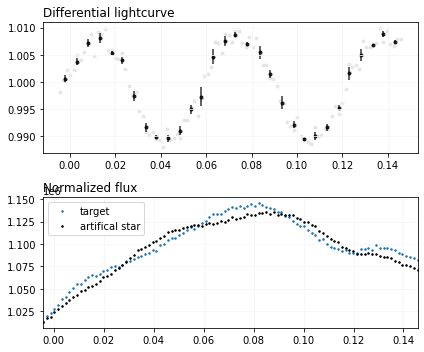

In [15]:
plt.figure(figsize=(6, 5))
df.plot_raw_diff()

To see all possible plotting options check the `Observation` API

### Skiping the reduction

For some reasons you might want to run the reduction without doing any calibration. In that case the `calibration=False` kwarg can be used:

In [16]:
from prose import Reduction

uncalibrated_folder = "uncalibrated_folder"

reduction2 = Reduction(fm, calibration=False)
reduction2.run(destination=uncalibrated_folder)

RUN Reduction: 100%|███████████████████████| 100/100 [00:09<00:00, 10.16files/s]


In [17]:
# hidden
from shutil import rmtree

rmtree(reduction.destination)
rmtree(reduction2.destination)
rmtree(fits_folder)